# CHECK THIS DATA WITH THE ORIGINAL PAPER IF COINCIDES!!!!

In [55]:
import polars as pl

In [56]:
df = pl.read_parquet("../data/preprocessed/data_avg_brand.parquet")
df_tgp = pl.read_parquet("../data/preprocessed/tgp.parquet")

In [57]:
df.head()

publish_date,brand_description,avg_price
date,str,f64
2001-01-03,"""BP""",86.87
2001-01-03,"""Caltex""",87.66
2001-01-03,"""Caltex Woolworths""",86.95
2001-01-03,"""Gull""",84.08
2001-01-04,"""BP""",85.33


In [58]:
df_tgp.head()

date,tgpmin
date,f64
2002-12-19,84.7
2002-12-20,85.3
2002-12-21,85.3
2002-12-22,85.3
2002-12-23,85.3


In [59]:
df = (
    df.join(df_tgp, left_on="publish_date", right_on="date", how="left")
    # rename brand_description. Caltex Woolworths to Woolworths and Coles Express to Coles
    .with_columns(
        pl.when(pl.col("brand_description") == "Caltex Woolworths")
        .then(pl.lit("Woolworths"))
        .when(pl.col("brand_description") == "Coles Express")
        .then(pl.lit("Coles"))
        .otherwise(pl.col("brand_description"))
        .alias("brand_description")
    )
)
df

publish_date,brand_description,avg_price,tgpmin
date,str,f64,f64
2001-01-03,"""BP""",86.87,null
2001-01-03,"""Caltex""",87.66,null
2001-01-03,"""Woolworths""",86.95,null
2001-01-03,"""Gull""",84.08,null
2001-01-04,"""BP""",85.33,null
…,…,…,…
2025-06-20,"""Caltex""",180.84,162.3
2025-06-21,"""BP""",174.47,163.2
2025-06-21,"""Caltex""",176.12,163.2


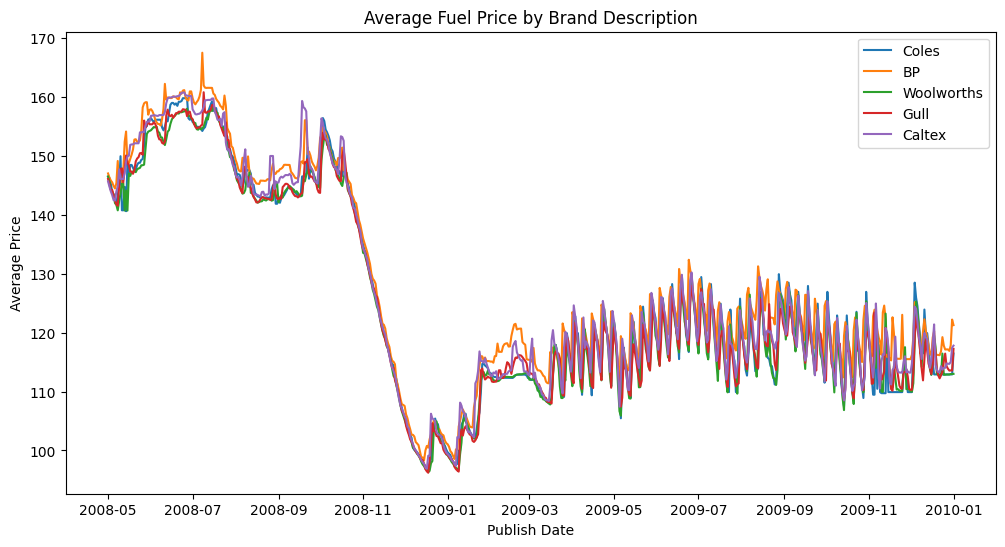

In [ ]:
import matplotlib.pyplot as plt

# make a plot of avg_price by brand_description and publish_date since 2008-05-01 till 2010
df_filtered = df.filter(pl.col("publish_date") >= pl.datetime(2008, 5, 1)).filter(
    pl.col("publish_date") <= pl.datetime(2010, 1, 1)
)
df_filtered = df_filtered.filter(
    pl.col("brand_description").is_in(["BP", "Caltex", "Woolworths", "Coles", "Gull"])
)
df_filtered = df_filtered.sort("publish_date")


plt.figure(figsize=(12, 6))
for brand in df_filtered["brand_description"].unique():
    brand_df = df_filtered.filter(pl.col("brand_description") == brand)
    plt.plot(brand_df["publish_date"], brand_df["avg_price"], label=brand)
plt.xlabel("Publish Date")
plt.ylabel("Average Price")
plt.title("Average Fuel Price by Brand Description")
plt.legend()
plt.show()

In [61]:
from datetime import datetime


def generate_initial_real_data(
    df: pl.DataFrame, memory_length: int, start_date: str
) -> dict:
    """
    Creates initial_real_data dict for simulation using real price data before a given start_date,
    including marginal cost.

    Args:
        df (pl.DataFrame): DataFrame with columns ['publish_date', 'brand_description', 'avg_price', 'tgpmin']
        memory_length (int): Number of past days (per brand) to use as memory
        start_date (str): ISO-format date string (e.g., '2024-12-01') treated as round 1

    Returns:
        dict[str, list[dict]]: initial_real_data formatted for Experiment
    """
    required_cols = {"publish_date", "brand_description", "avg_price", "tgpmin"}
    if not required_cols.issubset(set(df.columns)):
        raise ValueError(f"DataFrame must contain: {required_cols}")

    start_date_obj = datetime.strptime(start_date, "%Y-%m-%d").date()

    # Filter rows strictly before the start_date
    df_filtered = df.filter(pl.col("publish_date") < start_date_obj).sort(
        "publish_date"
    )

    initial_real_data = {}
    brands = df_filtered["brand_description"].unique().to_list()

    for brand in brands:
        brand_df = df_filtered.filter(pl.col("brand_description") == brand).sort(
            "publish_date"
        )

        if len(brand_df) < memory_length:
            raise ValueError(
                f"Not enough data for brand '{brand}' before {start_date} to fill {memory_length} rounds."
            )

        last_entries = brand_df.tail(memory_length)
        prices = last_entries["avg_price"].to_list()
        costs = last_entries["tgpmin"].to_list()

        initial_real_data[brand] = [
            {
                "round": -i,
                "chosen_price": round(
                    float(price) / 100, 2
                ),  # assuming prices are in cents
                "marginal_cost": round(float(cost) / 100, 2),
            }
            for i, (price, cost) in enumerate(zip(prices[::-1], costs[::-1]), start=0)
        ]

    return initial_real_data

In [62]:
initial_real_data = generate_initial_real_data(
    df, memory_length=100, start_date="2009-07-01"
)

In [63]:
initial_real_data

{'Woolworths': [{'round': 0, 'chosen_price': 1.19, 'marginal_cost': 1.17},
  {'round': -1, 'chosen_price': 1.22, 'marginal_cost': 1.18},
  {'round': -2, 'chosen_price': 1.24, 'marginal_cost': 1.18},
  {'round': -3, 'chosen_price': 1.26, 'marginal_cost': 1.18},
  {'round': -4, 'chosen_price': 1.28, 'marginal_cost': 1.18},
  {'round': -5, 'chosen_price': 1.27, 'marginal_cost': 1.19},
  {'round': -6, 'chosen_price': 1.17, 'marginal_cost': 1.19},
  {'round': -7, 'chosen_price': 1.18, 'marginal_cost': 1.19},
  {'round': -8, 'chosen_price': 1.21, 'marginal_cost': 1.19},
  {'round': -9, 'chosen_price': 1.22, 'marginal_cost': 1.19},
  {'round': -10, 'chosen_price': 1.25, 'marginal_cost': 1.19},
  {'round': -11, 'chosen_price': 1.28, 'marginal_cost': 1.19},
  {'round': -12, 'chosen_price': 1.26, 'marginal_cost': 1.18},
  {'round': -13, 'chosen_price': 1.17, 'marginal_cost': 1.18},
  {'round': -14, 'chosen_price': 1.18, 'marginal_cost': 1.18},
  {'round': -15, 'chosen_price': 1.2, 'marginal_cost

In [64]:
import json

with open("initial_real_data.json", "w") as f:
    json.dump(initial_real_data, f, indent=2)

In [65]:
df = df.filter(
    (pl.col("publish_date") >= pl.datetime(2009, 7, 1))
    & (pl.col("publish_date") < pl.datetime(2012, 5, 1))
)
df

publish_date,brand_description,avg_price,tgpmin
date,str,f64,f64
2009-07-01,"""BP""",128.23,117.4
2009-07-01,"""Caltex""",120.04,117.4
2009-07-01,"""Woolworths""",116.45,117.4
2009-07-01,"""Coles""",116.7,117.4
2009-07-01,"""Gull""",117.91,117.4
…,…,…,…
2012-04-30,"""BP""",149.44,139.4
2012-04-30,"""Caltex""",148.49,139.4
2012-04-30,"""Woolworths""",148.55,139.4


In [66]:
df_tgp_final = (
    df.group_by("publish_date")
    .agg(pl.col("tgpmin").min().alias("tgpmin"))
    .sort("publish_date")
)
df_tgp_final

publish_date,tgpmin
date,f64
2009-07-01,117.4
2009-07-02,117.4
2009-07-03,116.9
2009-07-04,116.9
2009-07-05,116.9
…,…
2012-04-26,140.1
2012-04-27,139.2
2012-04-28,139.4


In [67]:
df_tgp_final.write_parquet("marginal_costs.parquet")

In [68]:
df_bp = df.filter(pl.col("brand_description") == "BP").select(
    ["publish_date", "avg_price"]
)
df_caltex = df.filter(pl.col("brand_description") == "Caltex").select(
    ["publish_date", "avg_price"]
)
df_woolworths = df.filter(pl.col("brand_description") == "Woolworths").select(
    ["publish_date", "avg_price"]
)
df_coles = df.filter(pl.col("brand_description") == "Coles").select(
    ["publish_date", "avg_price"]
)
df_gull = df.filter(pl.col("brand_description") == "Gull").select(
    ["publish_date", "avg_price"]
)


df_bp.write_parquet("bp_prices.parquet")
df_caltex.write_parquet("caltex_prices.parquet")
df_woolworths.write_parquet("woolworths_prices.parquet")
df_coles.write_parquet("coles_prices.parquet")
df_gull.write_parquet("gull_prices.parquet")